# Úkol č. 1 - vytvořte klasifikátor

> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroje dat

  * Primárním zdrojem dat je Vámi vybraný dataset (Kdo nemá vezme si tento: https://www.kaggle.com/c/DontGetKicked/data)

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte až **5 bodů** za každý bod:
  * předzpracování dat (**až 5 bodů**). Například, najít příznaky v textových datech, doplnit chybějící hodnoty, kategorizovat numerická data atd.
  * vizualizace dat (**až 5 bodů**). Vizualizace různých příznaků pro pozorování závislostí.
  * implementace algoritmu (**až 5 bodů**), zkuste použít více než jeden!
  
  
## Poznámky k odevzdání

  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body.
  * Deadline pro odevzdání (nahrát na GitLab) je 7/4/2020 o půlnoci.
  * Dobrý (až moc) příklad pro inspiraci: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [ ]:
import pandas as pd
import folium
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pyowm
import json
from sklearn.model_selection import train_test_split
from folium.plugins import HeatMap
from scipy import stats
from h3 import h3
from math import radians, cos, sin, asin, sqrt
import branca.colormap as cm
from branca.colormap import linear
from geojson.feature import GeoJSON, Feature, FeatureCollection
from geojson import GeoJSON
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

plt.rcParams['figure.figsize'] = [16, 10]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip3.7 install pyowm

# New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

The goal is to aproximate a trip duration by taxi at NYC.

#### Load Dataset

In [3]:
url = 'nyc-taxi-trip-duration/train.csv'
df = pd.read_csv(url, parse_dates=['pickup_datetime', 'dropoff_datetime'])
df.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

## Data Preprocessing

Any missing data?

In [4]:
df.isnull().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### Data Types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


Good for now...

### Feature Exploration

#### Target Variable - Trip Duration

Target variable is a duration of taxi ride from point A to point B at NYC.

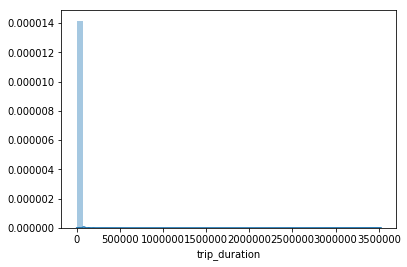

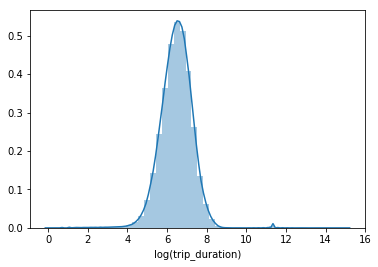

In [6]:
sns.distplot(df['trip_duration'].values, axlabel = 'trip_duration')
plt.show()
sns.distplot(np.log(df['trip_duration'].values), axlabel = 'log(trip_duration)')
plt.show()

It seems that the dataset has some serious outliers.
We will remove the outliers from the dataset using z-score.

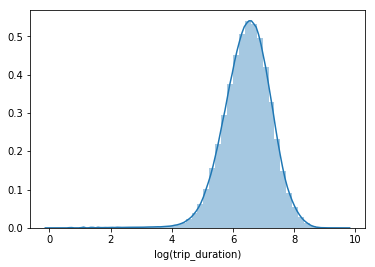

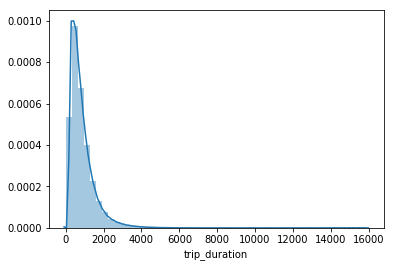

In [7]:
threshold = 3
z_score = np.abs(stats.zscore(df['trip_duration']))
df = df[(z_score < 3)]

sns.distplot(np.log(df['trip_duration'].values), axlabel = 'log(trip_duration)')
plt.show()
sns.distplot(df['trip_duration'].values, axlabel = 'trip_duration')
plt.show()

### Pick & Drop Locations

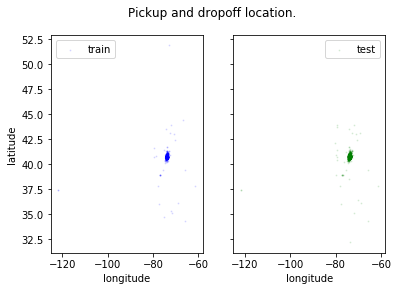

In [8]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df['pickup_longitude'].values, df['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df['dropoff_longitude'].values, df['dropoff_latitude'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Pickup and dropoff location.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.show()

We got multiple points very far from NYC, the let's focus just on the NYC boarders.

In [9]:
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]

df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

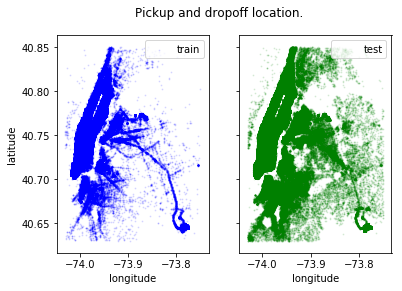

In [10]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df['pickup_longitude'].values, df['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df['dropoff_longitude'].values, df['dropoff_latitude'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Pickup and dropoff location.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.show()

We have reduced a number of points because many were out the of the NYC area.

#### Heatmaps

In [11]:
from folium.plugins import HeatMap

pickup_data = df[['pickup_latitude', 'pickup_longitude']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
dropoff_data = df[['dropoff_latitude', 'dropoff_longitude']].groupby(['dropoff_latitude', 'dropoff_longitude']).sum().reset_index().values.tolist()

base_map = folium.Map(location=[40.7127837, -74.0059413], zoom_start=13)
HeatMap(data=pickup_data, radius=10, max_zoom=13).add_to(base_map)
base_map.save('pickup_heatmap.html')

base_map = folium.Map(location=[40.7127837, -74.0059413], zoom_start=13)
HeatMap(data=dropoff_data, radius=10, max_zoom=13).add_to(base_map)
base_map.save('dropoff_heatmap.html')

The previous cell generates a heatmap of pickup and dropoff locations. You may check the in generated files.

## Feature Engineering

#### Haversine Distance 

In [12]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [13]:
df['trip_distance'] = df.apply(lambda x: haversine_distance(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

#### H3

H3 is an extremly useful tool for spatial analysis developed by Uber. You may locate yourself with single hex and given resolution. 

I'm gonna use it for clustering coords into single hexagon.

https://towardsdatascience.com/geospatial-indexing-with-ubers-h3-766399b690c

In [14]:
hexagon_res = 10

In [15]:
df['pickup_hex'] = df.apply(lambda x: h3.geo_to_h3(x['pickup_latitude'], x['pickup_longitude'], hexagon_res), axis = 1)
df['dropoff_hex'] = df.apply(lambda x: h3.geo_to_h3(x['dropoff_latitude'], x['dropoff_longitude'], hexagon_res), axis = 1)

In [16]:
# folium_map = folium.Map(location=[40.7127837, -74.0059413], zoom_start=10)
# folium_map

In [17]:
def counts_by_hexagon(df, resolution):
    
    '''Use h3.geo_to_h3 to index each data point into the spatial index of the specified resolution.
      Use h3.h3_to_geo_boundary to obtain the geometries of these hexagons'''

    df = df[["pickup_latitude","pickup_longitude"]]
    
    df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["pickup_latitude"], row["pickup_longitude"], resolution), axis = 1)
    
    df_aggreg = df.groupby(by = "hex_id").size().reset_index()
    df_aggreg.columns = ["hex_id", "value"]
    
    df_aggreg["geometry"] =  df_aggreg.hex_id.apply(lambda x: {"type" : "Polygon","coordinates": [h3.h3_to_geo_boundary(h3_address=x,geo_json=True)]})
    
    return df_aggreg

In [18]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=2,color=color)
        m.add_child(my_PolyLine)
        
    m.save('hexagons.html')

In [19]:
df_aggreg = counts_by_hexagon(df, resolution=10)

In [20]:
visualize_hexagons(df_aggreg['hex_id'].values)

#### Clustering

In [21]:
from sklearn.cluster import MiniBatchKMeans

coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=1000, batch_size=10000).fit(coords[sample_ind])

df.loc[:, 'pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']])
df.loc[:, 'dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']])
df.loc[:, 'pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']])
df.loc[:, 'dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']])

#### Type of the day

In [22]:
import holidays
us_holidays = holidays.US()
df['is_holiday'] = df.apply(lambda x: x['pickup_datetime'] in us_holidays, axis=1)
df['is_holiday'] = df['is_holiday'].astype('int')

In [23]:
df['hour'] = df['pickup_datetime'].apply(lambda time: time.hour)
df['hour'] = df['pickup_datetime'].apply(lambda time: time.month)
df['day'] = df['pickup_datetime'].apply(lambda time: time.day)
df['year'] = df['pickup_datetime'].apply(lambda t: t.year)
df['date'] = df['pickup_datetime'].apply(lambda t: t.strftime("%d-%m-%Y"))

In [24]:
df['date'] = pd.to_datetime(df['date'])

#### Weather Feature

In [25]:
df_weather = pd.read_csv('weather_data_nyc_centralpark_2016.csv', parse_dates=['date'])

In [26]:
cols = ['precipitation', 'snow fall', 'snow depth']
df_weather[cols] = df_weather[cols].replace({'T': '0'})

df_weather[cols] = df_weather[cols].astype('float')

In [27]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 366 non-null    datetime64[ns]
 1   maximum temperature  366 non-null    int64         
 2   minimum temperature  366 non-null    int64         
 3   average temperature  366 non-null    float64       
 4   precipitation        366 non-null    float64       
 5   snow fall            366 non-null    float64       
 6   snow depth           366 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 20.1 KB


In [28]:
df = pd.merge(df_weather, df, on='date', how='right')
df.head()

date  maximum temperature  minimum temperature  average temperature  \
0 2016-01-01                   42                   34                 38.0   
1 2016-01-01                   42                   34                 38.0   
2 2016-01-01                   42                   34                 38.0   
3 2016-01-01                   42                   34                 38.0   
4 2016-01-01                   42                   34                 38.0   

   precipitation  snow fall  snow depth         id  vendor_id  \
0            0.0        0.0         0.0  id3620795          1   
1            0.0        0.0         0.0  id2336715          2   
2            0.0        0.0         0.0  id0645865          2   
3            0.0        0.0         0.0  id3806962          2   
4            0.0        0.0         0.0  id2987313          2   

      pickup_datetime  ... trip_duration  trip_distance       pickup_hex  \
0 2016-01-01 10:45:24  ...           383       1.718681  8a2a100d24dffff   
1 2016-01-01 00:09:03  ...           622       3.796840  8a2a100d2d6ffff   
2 2016-01-01 03:49:48  ...           185       1.413029  8a2a1008d60ffff   
3 2016-01-01 15:48:58  ...           280       2.173691  8a2a1072c08ffff   
4 2016-01-01 09:47:11  ...           166       0.805724  8a2a100d2d9ffff   

       dropoff_hex  pickup_cluster  dropoff_cluster is_holiday  hour  day  \
0  8a2a1072c8c7fff             279              864          1     1    1   
1  8a2a1072c357fff             932              940          1     1    1   
2  8a2a10088b9ffff              51               41          1     1    1   
3  8a2a100d2737fff             887              662          1     1    1   
4  8a2a10725a17fff             323               10          1     1    1   

   year  
0  2016  
1  2016  
2  2016  
3  2016  
4  2016  

[5 rows x 27 columns]

### Feature Types & Selection

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437158 entries, 0 to 1437157
Data columns (total 27 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   date                 1437158 non-null  datetime64[ns]
 1   maximum temperature  1437158 non-null  int64         
 2   minimum temperature  1437158 non-null  int64         
 3   average temperature  1437158 non-null  float64       
 4   precipitation        1437158 non-null  float64       
 5   snow fall            1437158 non-null  float64       
 6   snow depth           1437158 non-null  float64       
 7   id                   1437158 non-null  object        
 8   vendor_id            1437158 non-null  int64         
 9   pickup_datetime      1437158 non-null  datetime64[ns]
 10  dropoff_datetime     1437158 non-null  datetime64[ns]
 11  passenger_count      1437158 non-null  int64         
 12  pickup_longitude     1437158 non-null  float64       
 1

In [30]:
df['is_holiday'] = df['is_holiday'].astype('int')

In [31]:
df = df.drop(columns=['id', 'store_and_fwd_flag', 'pickup_hex', 'dropoff_hex'])

### Matrix Correlation

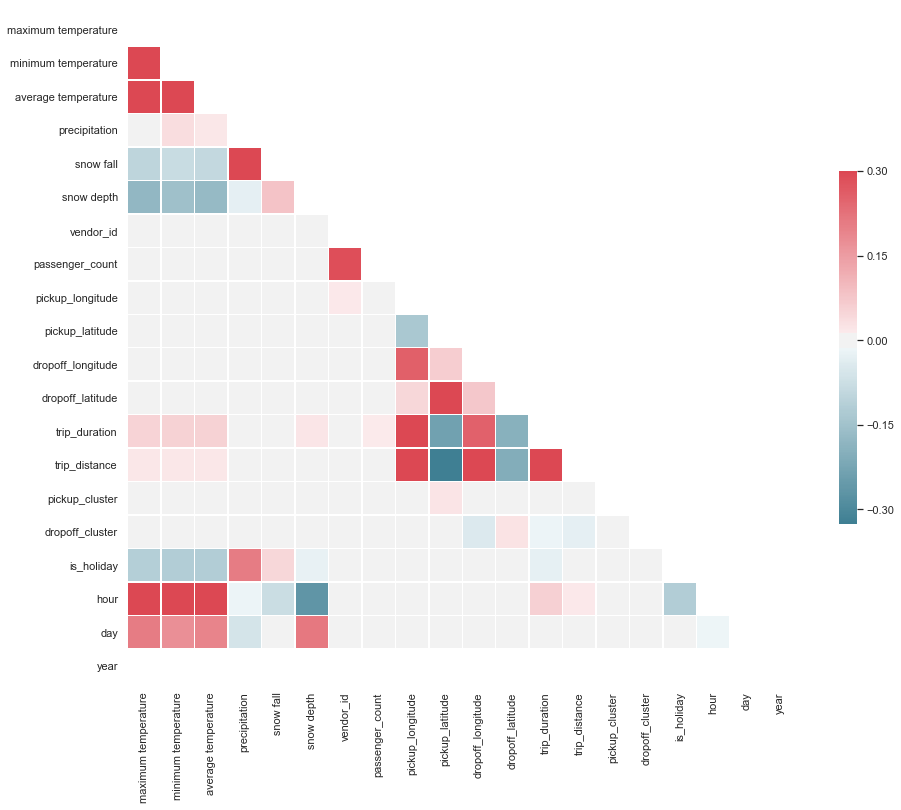

In [32]:
sns.set(style="white")

# Generate a large random dataset
temp3 = df.copy()

# Compute the correlation matrix
corr = temp3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Prepare Dataset

In [33]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category') 

In [34]:
df.select_dtypes(include=['int']).nunique().sort_values(ascending=True)

year                      1
vendor_id                 2
is_holiday                2
hour                      6
passenger_count           7
day                      31
minimum temperature      59
maximum temperature      61
trip_duration          6014
dtype: int64

In [35]:
df = pd.get_dummies(df)

### Load Test Dataset

In [36]:
# url = 'nyc-taxi-trip-duration/test.csv'
# df_test = pd.read_csv(url, parse_dates=['pickup_datetime'])
# df_test.head()

## Classification

In [50]:
#df_train = df.drop(columns=['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'])
df_train = df.drop(columns=['pickup_datetime', 'dropoff_datetime', 'date'])

In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437158 entries, 0 to 1437157
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   maximum temperature  1437158 non-null  int64  
 1   minimum temperature  1437158 non-null  int64  
 2   average temperature  1437158 non-null  float64
 3   precipitation        1437158 non-null  float64
 4   snow fall            1437158 non-null  float64
 5   snow depth           1437158 non-null  float64
 6   vendor_id            1437158 non-null  int64  
 7   passenger_count      1437158 non-null  int64  
 8   pickup_longitude     1437158 non-null  float64
 9   pickup_latitude      1437158 non-null  float64
 10  dropoff_longitude    1437158 non-null  float64
 11  dropoff_latitude     1437158 non-null  float64
 12  trip_duration        1437158 non-null  int64  
 13  trip_distance        1437158 non-null  float64
 14  pickup_cluster       1437158 non-null  int32  
 15

In [51]:
x_train, x_test, y_train, y_test = train_test_split(df_train.drop(columns=['trip_duration']), df_train['trip_duration'], test_size=0.2, random_state=42)

In [76]:
def rmsle(x, y):
    return np.sqrt(mean_squared_error(x, np.log(y)))

def mse(x, y):
    return np.sqrt(mean_squared_error(x, y))

### Random Forrest

In [77]:
model = RandomForestRegressor(max_depth=70)
model.fit(x_train, y_train)

print('Root mean squared logarithmic error (train):', rmsle(model.predict(x_train), y_train))
print('Root mean squared logarithmic error (test):', rmsle(model.predict(x_test), y_test))

print('Root mean squared error (train):', mse(model.predict(x_train), y_train))
print('Root mean squared error (test):', mse(model.predict(x_test), y_test))

Root mean squared logarithmic error (train): 1015.022705977184
Root mean squared logarithmic error (test): 1001.5278072994887
Root mean squared error (train): 159.4039835880518
Root mean squared error (test): 375.89534876224656


#### GridSearch

In [72]:
def find_best_hyperparams(regressor, params, x_train, y_train):
    
    grid_search = GridSearchCV(estimator=regressor,  iparam_grid=hyperparams)
    
    grid_search.fit(x_train, np.log(y_train))

    print(f'Best score: {grid_search.best_score_}')

    print("Set hyperparameters:")
    best_parameters=grid_search.best_estimator_.get_params()
    for param_name in sorted(hyperparams.keys()):
        print(f'\t{param_name} : {best_parameters[param_name]}')
    
    return grid_search.best_estimator_

In [68]:
hyperparams = {'n_estimators': [5, 10, 25, 50, 100, 150, 200],
              'max_depth': list(range(1, 50, 3))}

In [73]:
best_model = find_best_hyperparams(RandomForestRegressor(), hyperparams, x_train, y_train)

print('Root mean squared logarithmic error (train):', rmsle(best_model.predict(x_train), y_train))
print('Root mean squared logarithmic error (test):', rmsle(best_model.predict(x_test), y_test))

KeyboardInterrupt: 

### XGBoost

In [56]:
xg_reg = xgb.XGBRegressor(
    objective ='reg:linear', 
    colsample_bytree = 0.3, 
    learning_rate = 0.1, 
    max_depth = 5, 
    alpha = 10, 
    n_estimators = 10)

In [63]:
xg_reg.fit(x_train, y_train)

train_preds = xg_reg.predict(x_train)
test_preds = xg_reg.predict(x_test)

print('Root mean squared logarithmic error (train):', rmsle(train_preds, y_train))
print('Root mean squared logarithmic error (test):', rmsle(test_preds, y_test))

[22:19:18] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:19:23] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
Root mean squared logarithmic error (train): 556.2073303169357
Root mean squared logarithmic error (test): 555.7981150409244


In [ ]:
# pred = model.predict(dtest)
# pred = np.exp(pred) - 1

### GridSearch

In [ ]:
hyperparams = {'n_estimators': [3, 5, 10, 50, 100, 150, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
              'gamma':[0.025, 0.05, 0.075, 0.1, 0.2]}

In [ ]:
best_model = find_best_hyperparams(xgboost.sklearn.XGBRegressor(), hyperparams, x_train, y_train)

print('Root mean squared logarithmic error (train):', rmsle(best_model.predict(x_train), y_train))
print('Root mean squared logarithmic error (test):', rmsle(best_model.predict(x_test), y_test))